## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from scipy import stats

# 1. Construir la URL de la API del BCRP
base_url = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api"
series = "PD04637PD-PD04639PD-PD04704XD-PD04701XD"
formato = "json"
periodo = "2023-01-01/2023-12-31" # Ejemplo para el año 2023

url_bcrp = f"{base_url}/{series}/{formato}/{periodo}"
print(f"URL BCRP: {url_bcrp}")

URL BCRP: https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json/2023-01-01/2023-12-31


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [4]:
# 2. Descargar y procesar a formato Tidy
url_bcrp = "https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json/2023-01-01/2023-12-31"
response = requests.get(url_bcrp).json()
data_list = []
for p in response['periods']:
    date = p['name']
    for i, val in enumerate(p['values']):
        # Limpiamos el valor: si es "n.d." ponemos NaN, de lo contrario a float
        clean_val = float(val) if val != "n.d." else np.nan
        data_list.append({'date': date, 'series_id': i, 'value': clean_val})

df_tidy = pd.DataFrame(data_list)
df_tidy

,date,series_id,value
0,03.Ene.23,0,3.813667
1,03.Ene.23,1,3.812000
2,03.Ene.23,2,380.563998
3,03.Ene.23,3,1843.250000
4,04.Ene.23,0,3.823833
...,...,...,...
1035,08.Dic.23,3,2004.670000
1036,25.Dic.23,0,NaN
1037,25.Dic.23,1,NaN
1038,25.Dic.23,2,385.508159


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [5]:
import requests
import pandas as pd
import numpy as np
# 3. Transformar a formato Wide con las columnas exactas
# Mapeo de los IDs de posición a los nombres solicitados
map_names = {0: 'fx_interbank', 1: 'fx_sbs', 2: 'gold', 3: 'copper'}
df_tidy['series_name'] = df_tidy['series_id'].map(map_names)

# Eliminamos duplicados antes del pivot para evitar errores
df_tidy = df_tidy.drop_duplicates(subset=['date', 'series_name'])

# Pivotamos usando los nombres nuevos
df_peru = df_tidy.pivot(index='date', columns='series_name', values='value')

# Limpiar el nombre de las columnas (quita el texto 'series_name' de arriba)
df_peru.columns.name = None

# Corregir las fechas (Español -> Inglés)
meses = {'Ene':'Jan','Feb':'Feb','Mar':'Mar','Abr':'Apr','May':'May','Jun':'Jun',
         'Jul':'Jul','Ago':'Aug','Set':'Sep','Oct':'Oct','Nov':'Nov','Dic':'Dec'}

new_idx = df_peru.index.to_series()
for esp, eng in meses.items():
    new_idx = new_idx.str.replace(esp, eng, regex=False)

# Convertir índice a Datetime
df_peru.index = pd.to_datetime(new_idx, format='%d.%b.%y')
df_peru = df_peru.sort_index().ffill()

# Seleccionar y ordenar las columnas finales
df_peru = df_peru[['fx_interbank', 'fx_sbs', 'gold', 'copper']]

print(df_peru.head())

            fx_interbank  fx_sbs        gold   copper
date                                                 
2023-01-02           NaN     NaN  380.427924  1843.25
2023-01-03      3.813667   3.812  380.563998  1843.25
2023-01-04      3.823833   3.822  372.353980  1857.30
2023-01-05      3.824333   3.824  381.924779  1834.00
2023-01-06      3.798000   3.800  379.316619  1852.20


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [8]:
import warnings
warnings.filterwarnings('ignore') # Oculta los warnings de futuras versiones

# Descarga silenciosa (progress=False)
df_usa_wide = yf.download(['SPY', 'TLT', 'GLD'],
                          start="2023-01-01",
                          end="2024-01-01",
                          progress=False)['Close']

# 4. Descargar y transformar a formato Tidy (date, ticker, close)
df_usa_wide = yf.download(['SPY', 'TLT', 'GLD'], start="2023-01-01", end="2024-01-01")['Close']

# .stack() pasa los tickers de las columnas a una fila por cada fecha
df_usa_tidy = df_usa_wide.stack().reset_index()
df_usa_tidy.columns = ['date', 'ticker', 'close']

print("Formato Tidy solicitado:")
print(df_usa_tidy.head())

[*********************100%***********************]  3 of 3 completed

Formato Tidy solicitado:
        date ticker       close
0 2023-01-03    GLD  171.059998
1 2023-01-03    SPY  366.069061
2 2023-01-03    TLT   90.171219
3 2023-01-04    GLD  172.669998
4 2023-01-04    SPY  368.895203


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


In [9]:
# Calculamos retornos en el formato wide para facilitar operaciones
df_ret = df_usa_wide.pct_change().dropna()
print(df_ret)
# Validar que no hay infinitos
has_inf = np.isinf(df_ret).values.any()
print(f"\nPunto 5 - ¿Existen valores infinitos en los retornos?: {has_inf}")

Ticker           GLD       SPY       TLT
Date                                    
2023-01-04  0.009412  0.007720  0.013700
2023-01-05 -0.012451 -0.011413  0.004181
2023-01-06  0.018707  0.022932  0.018397
2023-01-09  0.002245 -0.000567  0.005324
2023-01-10  0.003676  0.007013 -0.016550
...              ...       ...       ...
2023-12-22  0.004434  0.002010 -0.004549
2023-12-26  0.007621  0.004222  0.002843
2023-12-27  0.004538  0.001808  0.017720
2023-12-28 -0.005815  0.000378 -0.007263
2023-12-29 -0.001567 -0.002895 -0.009020

[249 rows x 3 columns]

Punto 5 - ¿Existen valores infinitos en los retornos?: False


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


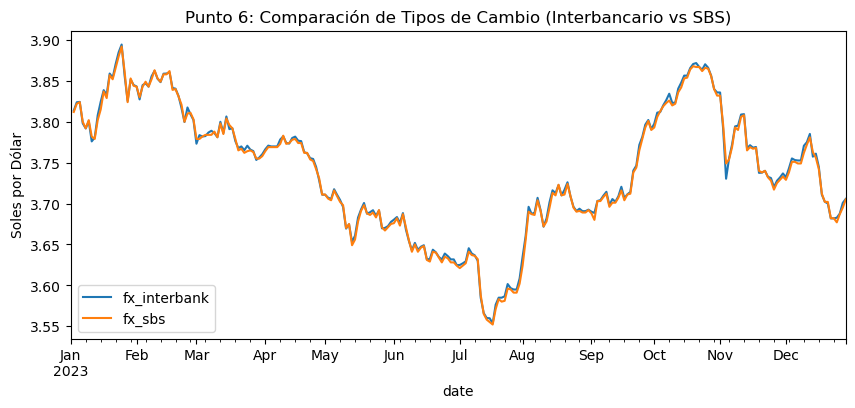

In [10]:
# --- PUNTO 6: Comparar FX niveles en Perú ---
df_peru[['fx_interbank', 'fx_sbs']].plot(figsize=(10, 4))
plt.title("Punto 6: Comparación de Tipos de Cambio (Interbancario vs SBS)")
plt.ylabel("Soles por Dólar")
plt.show()

Comentario: El tipo de cambio SBS suele ser ligeramente más estable que el interbancario, aunque ambos siguen la misma tendencia macroeconómica.

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [11]:
share_pos = (df_ret > 0).mean().sort_values()
print(share_pos)

Ticker
TLT    0.502008
GLD    0.510040
SPY    0.562249
dtype: float64


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


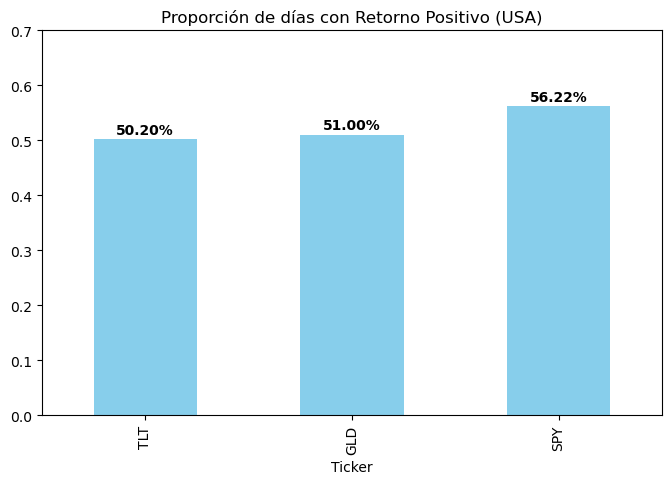

In [12]:
plt.figure(figsize=(8, 5))
ax = share_pos.plot(kind='bar', color='skyblue')
plt.title("Proporción de días con Retorno Positivo (USA)")
plt.ylim(0, 0.7)

# Anotaciones arriba de cada barra
for i, v in enumerate(share_pos):
    ax.text(i, v + 0.01, f"{v:.2%}", ha='center', fontweight='bold')
plt.show()

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


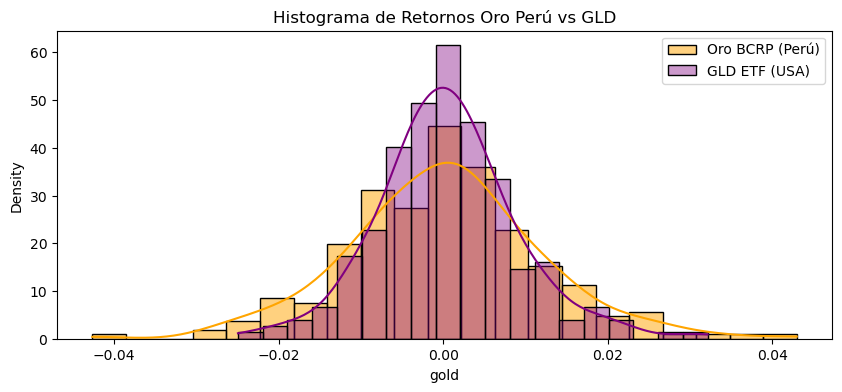

In [13]:
# Retornos del oro en Perú
peru_gold_ret = df_peru['gold'].pct_change().dropna()

plt.figure(figsize=(10, 4))
sns.histplot(peru_gold_ret, label='Oro BCRP (Perú)', kde=True, color='orange', stat="density")
sns.histplot(df_ret['GLD'], label='GLD ETF (USA)', kde=True, color='purple', alpha=0.4, stat="density")
plt.title("Histograma de Retornos Oro Perú vs GLD")
plt.legend()
plt.show()

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


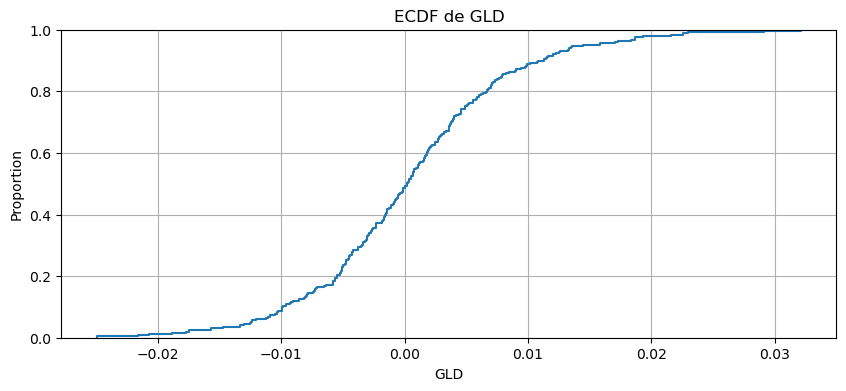

In [14]:
# ECDF
plt.figure(figsize=(10, 4))
sns.ecdfplot(df_ret['GLD'], label='GLD (ECDF)')
plt.title("ECDF de GLD")
plt.grid(True)
plt.show()

Comentario: El ECDF muestra la probabilidad acumulada. A diferencia del histograma, nos permite ver rápidamente qué porcentaje de los días el retorno fue menor a cero.

11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


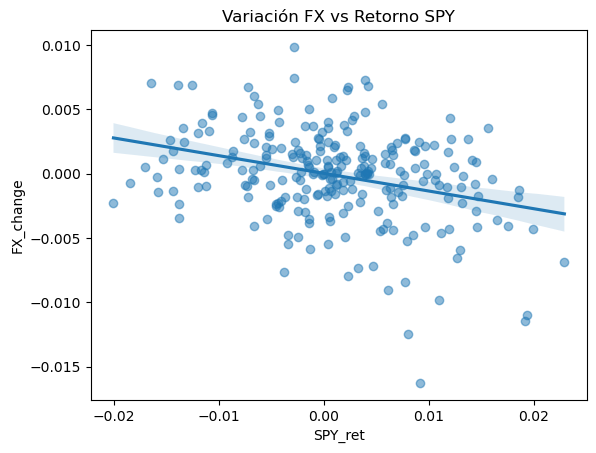

In [16]:
# Alineamos las fechas de ambos datasets y eleminamos los NA
df_rel = pd.DataFrame({
    'FX_change': df_peru['fx_interbank'].pct_change(),
    'SPY_ret': df_ret['SPY']
}).dropna()

# 11. Scatter plot
sns.regplot(data=df_rel, x='SPY_ret', y='FX_change', scatter_kws={'alpha':0.5})
plt.title("Variación FX vs Retorno SPY")
plt.show()

12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


In [25]:
correl = df_rel.corr().iloc[0,1]
print(f"\n Correlación: {correl:.4f}")


 Correlación: -0.3138


Explicación: El signo suele ser negativo porque el dólar actúa como refugio; cuando el mercado americano (SPY) cae, suele generar una depreciación en el dólar y, por lo tanto, el TC sol frente al dólar sube. 

13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


In [29]:
res = stats.linregress(df_rel['SPY_ret'], df_rel['FX_change'])
print(f" Beta (Coeficiente): {res.slope:.4f}")

 Beta (Coeficiente): -0.1372


Interpretación: Por cada 1% que sube el SPY, el tipo de cambio en Perú tiende a disminuir en 0.1372%.

14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


In [50]:
print("\nSelección con iloc \n")
#Selection exercise with iloc (just SPY)
df_jan=df_usa_wide.iloc[:12]
print(df_jan)

print("\nSelección con conditional filtering \n")
#Selection exercise with conditional filtering
print (df_usa_wide[df_usa_wide["SPY"] > 450])

print("\nLa selección con iloc solo muestra los 12 primeros días de mercado, mientras que la selección con filtro condicional muestra aquellos días en los que el SPY ha sido mayor que 450")


Selección con iloc 

Ticker             GLD         SPY        TLT
Date                                         
2023-01-03  171.059998  366.069061  90.171219
2023-01-04  172.669998  368.895203  91.406555
2023-01-05  170.520004  364.684875  91.788712
2023-01-06  173.710007  373.047882  93.477333
2023-01-09  174.100006  372.836365  93.974998
2023-01-10  174.740005  375.450989  92.419731
2023-01-11  174.619995  380.199707  93.921684
2023-01-12  176.639999  381.583923  95.770248
2023-01-13  178.759995  383.064209  94.872620
2023-01-17  177.589996  382.362518  94.259392
2023-01-18  177.080002  376.325775  96.543480
2023-01-19  179.889999  373.586151  95.939133

Selección con conditional filtering 

Ticker             GLD         SPY        TLT
Date                                         
2023-12-12  183.490005  451.074860  86.734741
2023-12-13  187.630005  457.295258  88.769737
2023-12-14  188.729996  458.762970  91.078911
2023-12-15  187.000000  458.007568  91.180046
2023-12-18  187.850

15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


In [60]:
df_peru_missing = df_peru['gold'].copy()
df_peru_missing.iloc[10:15] = np.nan
df_imputed = df_peru_missing.ffill()
print(df_imputed)

date
2023-01-02    380.427924
2023-01-03    380.563998
2023-01-04    372.353980
2023-01-05    381.924779
2023-01-06    379.316619
                 ...    
2023-12-25    385.508159
2023-12-26    385.508159
2023-12-27    386.075150
2023-12-28    386.914295
2023-12-29    384.464897
Name: gold, Length: 260, dtype: float64


16. Standardize a variable (z-score) and plot **before vs after**.  


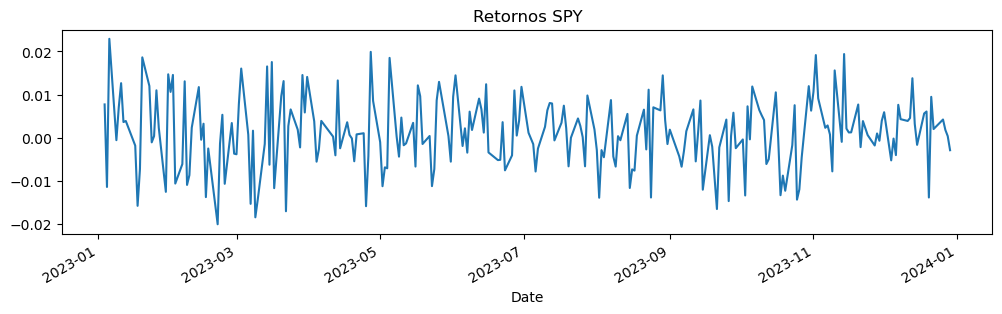

In [64]:
#Variable plot before
plt.figure(figsize=(12, 3))
df_ret['SPY'].plot(title="Retornos SPY")
plt.show()

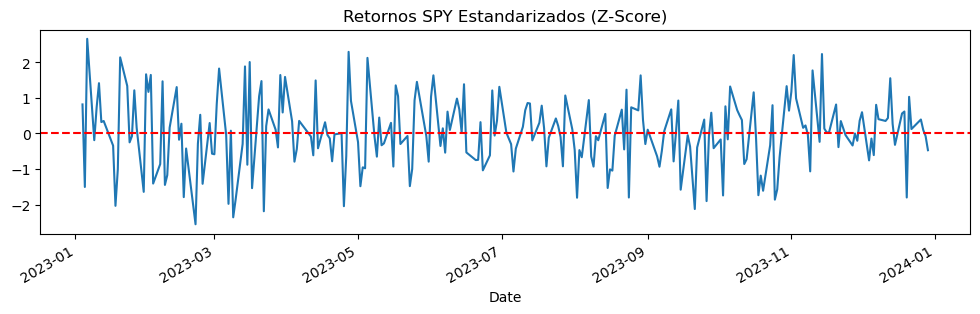

In [62]:
spy_z = (df_ret['SPY'] - df_ret['SPY'].mean()) / df_ret['SPY'].std()

#Standarized variable plot (After)
plt.figure(figsize=(12, 3))
spy_z.plot(title="Retornos SPY Estandarizados (Z-Score)")
plt.axhline(0, color='red', linestyle='--')
plt.show()

17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


Text(0.5, 1.0, ' Retornos SPY con anotación del día más volátil')

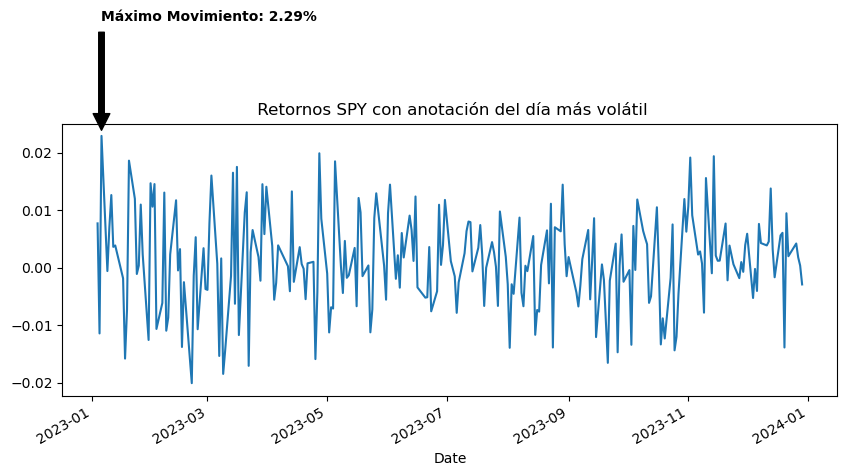

In [74]:
max_vol_date = df_ret['SPY'].abs().idxmax()
max_vol_val = df_ret.loc[max_vol_date, 'SPY']

plt.figure(figsize=(10, 4))
df_ret['SPY'].plot()
plt.annotate(f'Máximo Movimiento: {max_vol_val:.2%}',
             xy=(max_vol_date, max_vol_val),
             xytext=(max_vol_date, max_vol_val + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontweight='bold')
plt.title(" Retornos SPY con anotación del día más volátil")

18. Save one figure into `/figures` using `savefig` and verify the file exists.  



 Gráfico guardado en 'figures/spy_returns_annotated.png' exitosamente.


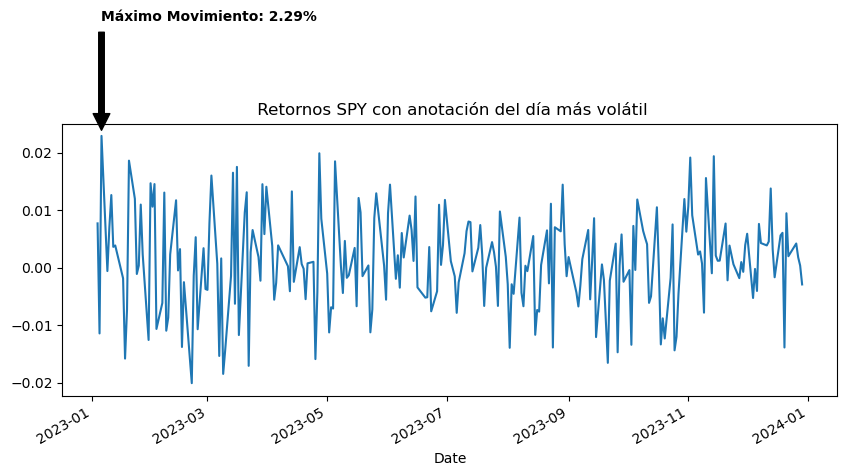

In [76]:
import os
import matplotlib.pyplot as plt

# Crear la carpeta 'figures' si no existe para evitar errores al guardar
if not os.path.exists('figures'):
    os.makedirs('figures')

# Grafico generado en el ejericio 17
plt.figure(figsize=(10, 4))
df_ret['SPY'].plot()
plt.annotate(f'Máximo Movimiento: {max_vol_val:.2%}',
             xy=(max_vol_date, max_vol_val),
             xytext=(max_vol_date, max_vol_val + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontweight='bold')
plt.title(" Retornos SPY con anotación del día más volátil")

#Guardar grafico en la carpeta figures
plt.savefig("figures/spy_returns_annotated.png")
print("\n Gráfico guardado en 'figures/spy_returns_annotated.png' exitosamente.")
plt.show()

19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


In [77]:
# Calculamos métricas clave para los retornos
summary_table = df_ret.agg(['mean', 'std', 'min', 'max',
                            lambda x: x.quantile(0.05),
                            lambda x: x.quantile(0.95)]).T
summary_table.columns = ['Media', 'Desv. Est', 'Min', 'Max', 'P5', 'P95']
print("\nResumen Estadístico de Retornos:\n")
print(summary_table)


Resumen Estadístico de Retornos:

           Media  Desv. Est       Min       Max        P5       P95
Ticker                                                             
GLD     0.000482   0.008439 -0.024958  0.032148 -0.012418  0.014099
SPY     0.000985   0.008247 -0.020061  0.022932 -0.013822  0.014505
TLT     0.000100   0.011571 -0.028834  0.034486 -0.017525  0.020404


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.


In [82]:
# Creamos el portafolio: 60% Acciones (SPY), 40% Bonos (TLT)
df_ret['Portfolio'] = 0.60 * df_ret['SPY'] + 0.40 * df_ret['TLT']

# Calculamos el cuantil 5% (VaR histórico al 95%)
var_95 = df_ret['Portfolio'].quantile(0.05)

print(f"\nHistorical 95% VaR para el Portafolio 60/40: {var_95:.2%}")
print(f"\nExplicación: En un día “normal” (95% de probabilidad según el histórico), la pérdida no debería ser menor que {var_95:.2%}. Pero en el peor 5% de días, la pérdida puede ser de {var_95:.2%} o peor.")


Historical 95% VaR para el Portafolio 60/40: -1.16%

Explicación: En un día “normal” (95% de probabilidad según el histórico), la pérdida no debería ser menor que -1.16%. Pero en el peor 5% de días, la pérdida puede ser de -1.16% o peor.
